In [3]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

fatal: destination path 'data/itv' already exists and is not an empty directory.


In [7]:
list(tasks.keys())

['location_continent',
 'football_player_position',
 'location_religion',
 'location_language',
 'person_profession',
 'location_country',
 'country_capital',
 'person_language',
 'singular_plural',
 'present_simple_past_simple',
 'antonyms',
 'plural_singular',
 'present_simple_past_perfect',
 'present_simple_gerund',
 'en_it',
 'it_en',
 'en_fr',
 'en_es',
 'fr_en',
 'es_en',
 'algo_last',
 'algo_first',
 'algo_second']

In [8]:
task_names = ["en_es", "antonyms", "person_profession"]
task_name = task_names[0]
task_name = "antonyms"

In [9]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task = tasks[task_name]

print(len(task))

# task = {
#     k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
# }

print(len(task))

pairs = list(task.items())

batch_size = 6
n_shot=6
if task_name.startswith("algo"):
    n_shot = 8
max_seq_len = 32
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt, use_same_examples=False, use_same_target=False)


layers = list(range(2, 18))
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)

162
162
Setting up masks...
Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/16 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
layer = 7

In [11]:

layers = [layer]
average_over_positions = True
# layers = [5]
orig_metric = circuitizer.ablated_metric(llama).tolist()
zero_metric = circuitizer.run_ablated_metrics([100000], layers=layers, average_over_positions=average_over_positions)[0][0]

print(orig_metric, zero_metric)

  0%|          | 0/1 [00:00<?, ?it/s]

8.625 -9.3125


In [12]:
import numpy as np
thresholds = np.linspace(-1, 1e-7, 2000)
# thresholds = np.linspace(1.4 * 1e-4, 1.45 * 1e-4, 200)
# thresholds = np.logspace(-3, 0, 150)
topks = [4, 6, 12, 16, 24, 32]

inverse = False
do_abs = False
mean_ablate = False


# ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds, inverse=inverse, 
#                                                                   do_abs=do_abs, mean_ablate=mean_ablate, 
#                                                                   average_over_positions=average_over_positions,
#                                                                   token_prefix=None, layers=layers)

# faithfullness = np.array(ablated_metrics)
# faithfullness = (faithfullness - zero_metric) / (orig_metric - zero_metric)



# target_metric = (max(ablated_metrics) - min(ablated_metrics)) * 0.95 + min(ablated_metrics)
# target_threshold = [threshold for threshold, metric in reversed(list(zip(thresholds, ablated_metrics))) if metric > target_metric][0]

In [13]:
from micrlhf.llama import LlamaBlock
from micrlhf.sampling import jit_wrapper


def make_taker(llama, layer):
    taker = jit_wrapper.Jitted(llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(
        lambda i, x: x if i >= layer else pz.nn.Identity()
    ).select().at_instances_of(pz.nn.EmbeddingLookup).apply(lambda _: pz.nn.Identity())
                    .select().at_instances_of(pz.nn.ConstantRescale).pick_nth_selected(0).apply(lambda _: pz.nn.Identity()))

    return taker


In [14]:

layers_to_check = list(range(2, 18))
takers = {
    layer: make_taker(llama, layer) for layer in layers_to_check
}

In [15]:
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import plotly.graph_objects as go
import jax.numpy as jnp

ies = {
    "resid": circuitizer.ie_resid,
    "attn_out": circuitizer.ie_attn,
    "transcoder": circuitizer.ie_transcoder,
}


mask_names = circuitizer.masks.keys()
token_types = ["input", "arrow", "output"]


def calc_effects(token_type, feature_type):
    effects = {}
    
    for layer in tqdm(layers_to_check):
        try:
            node_ies = circuitizer.mask_average(ies[feature_type][layer], token_type)
        except KeyError:
            continue
        non_zero_idx = np.where(node_ies != 0)[0]
        feat_metrics = []

        feat_metrics = circuitizer.run_single_feature_ablations(
            non_zero_idx, layer, token_type, feature_type, takers
        )

        effects[layer] = {
            "ies": node_ies[non_zero_idx],
            "metrics": [orig_metric - metric for metric in feat_metrics],
            "idx": non_zero_idx,
        }

    return effects

combined_effects = {}

_feature_types = ["resid", "attn_out", "transcoder"]

for layer in tqdm(layers_to_check):
    feature_types = _feature_types
    if layer == 17:
        feature_types = ["resid", "attn_out"]
    feature_masks = []
    all_node_ies = []
    all_idx = []
    for feature_type in feature_types:
        # for token_type in ["input", "arrow", "output"]:
        # for token_type in ["remaining"]:
        for token_type in token_types:
            node_ies = circuitizer.mask_average(ies[feature_type][layer], token_type)
            non_zero_idx = np.where(node_ies != 0)[0]

            other_masks = {}

            for ft in feature_types:
                if ft != feature_type:
                    masks = {
                        k: jnp.ones_like(node_ies).astype(jnp.bool) for k in mask_names
                    }
                    other_masks[ft] = masks

            for idx in non_zero_idx:
                masks = {
                    k: jnp.ones_like(node_ies).astype(jnp.bool) for k in mask_names
                }
                masks[token_type] = masks[token_type].at[idx].set(False)

                masks = {
                    feature_type: masks,
                    **other_masks
                }

                feature_masks.append(masks)
                all_node_ies.append((node_ies[idx].tolist(), token_type, feature_type))
                all_idx.append((idx, token_type, feature_type))

    feat_metrics = circuitizer.run_ablate_feature_masks(feature_masks, layer)

    combined_effects[layer] = {
        "node_ies": all_node_ies,
        "idx": all_idx,
        "metrics": feat_metrics
    }

        # effects = calc_effects(token_type, feature_type)
        # combined_effects[(token_type, feature_type)] = effects

  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:

from collections import defaultdict

transformed_effects = {}

for layer, effects in combined_effects.items():
    node_ies = effects["node_ies"]
    idx = effects["idx"]
    metrics = effects["metrics"]

    transformed_effects[layer] = defaultdict(lambda: defaultdict(lambda: {"ies": [], "metrics": [], "idx": []}))

    for ie, i, m in zip(node_ies, idx, metrics):
        token_type, feature_type = i[1:]

        transformed_effects[layer][token_type][feature_type][
            "ies"
        ].append(ie[0])

        transformed_effects[layer][token_type][feature_type][
            "metrics"
        ].append(orig_metric - m)

        transformed_effects[layer][token_type][feature_type][
            "idx"
        ].append(int(i[0]))



In [17]:
import json

with open("tmp.jsonl", "a") as f:
    f.write(json.dumps(transformed_effects) + "\n")

In [17]:
import json

# with open("../../results_correlation.jsonl") as f:
#     results = [json.loads(line) for line in f]
with open("tmp.jsonl") as f:
    data = f.read()
    data = data.split("\n")[-3].strip()

    # print(data[:1000])
    # data = data.split("}{")
    # data = "{" + data[-1]

    data = json.loads(data)

transformed_effects = data
transformed_effects = {int(k): v for k, v in transformed_effects.items()}


In [18]:
import plotly.express as px 
import json
import numpy as np


task_name = "antonyms"

# transformed_effects = {}

# for result in results:
#     if result["task_name"] == task_name:
#         transformed_effects = result["combined_effects"]

feature_types = ["resid", "attn_out", "transcoder"]
token_types = [f"prompt_{i}" for i in range(0, 5)]
token_types = ["input", "arrow", "output"]

layers_to_check = list(range(2, 18))[:-5]
heatmap = np.zeros((len(feature_types) * len(token_types), len(layers_to_check)))

row_titles = []

for ii, token_type in enumerate(token_types):
    for jj, feature_type in enumerate(feature_types):
        row_titles.append(f"{token_type} {feature_type}")

for layer in layers_to_check:
    if layer not in transformed_effects:
        print(layer)
        continue
    for ii, token_type in enumerate(token_types):
        for jj, feature_type in enumerate(feature_types):
            try:
                effects = transformed_effects[layer][token_type][feature_type]
                
                ies = effects["ies"]
                metrics = effects["metrics"]
                idx = effects["idx"]
                if len(ies) > 0:
                    corrcoef = np.corrcoef(ies, metrics)[0, 1]

                    heatmap[ii*3 + jj, layer-2] = corrcoef
            except KeyError as e:
                print(e)
                continue

px.imshow(heatmap, x=layers_to_check, y=row_titles, title=f"{task_name} batchsize=1 log_softmax=True", labels={"x": "Layer", "y": "Token Type, Feature Type"},
        zmin=-1, zmax=1, color_continuous_scale="RdBu").show()
          

# import 

# px.line(heatmap.mean(axis=0), title="Antonyms", labels={"x": "Layer", "y": "Mean Correlation Coefficient"}).show()

# heatmap.shape

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



In [21]:
# transformed_effects = results[task_name]
# transformed_effects = {int(k): v for k, v in transformed_effects.items()}


feature_types = ["resid", "attn_out", "transcoder"]
token_types = [f"prompt_{i}" for i in range(0, 5)]
token_types = ["input", "arrow", "output"]

layers_to_check = list(range(2, 18))
layer_data = {
    layer: [[], [], []] for layer in layers_to_check
}

row_titles = []

for ii, token_type in enumerate(token_types):
    for jj, feature_type in enumerate(feature_types):
        row_titles.append(f"{token_type} {feature_type}")

for layer in layers_to_check:
    if layer not in transformed_effects:
        print(layer)
        continue
    for ii, token_type in enumerate(token_types):
        for jj, feature_type in enumerate(feature_types):
            try:
                effects = transformed_effects[layer][token_type][feature_type]
                
                ies = effects["ies"]
                metrics = effects["metrics"]
                idx = effects["idx"]
                
                layer_data[layer][0].extend(ies)
                layer_data[layer][1].extend(metrics)
                layer_data[layer][2].extend([feature_type] * len(ies))

            except KeyError as e:
                print(e)

plotting_data = []

for layer, data in layer_data.items():
    ies, metrics, ft = data
    ies = np.array(ies)
    metrics = np.array(metrics)
    ft = np.array(ft)    
    for feature_type in feature_types:
        _ies = ies[ft == feature_type]
        _metrics = metrics[ft == feature_type]
        corrcoef = np.corrcoef(_ies, _metrics)[0, 1]
        plotting_data.append({
            "layer": layer,
            "correlation": corrcoef,
            "task_name": task_name,
            "feature_type": feature_type
        })

plotting_data

import pandas as pd
plot_df = pd.DataFrame(plotting_data)

print(plot_df)

px.line(plot_df, x="layer", y="correlation", color="feature_type", title=f"{task_name} batchsize=1 log_softmax=True", labels={"x": "Layer", "y": "Correlation Coefficient"}).show()

'attn_out'
'transcoder'
'transcoder'
'attn_out'
'transcoder'
    layer  correlation task_name feature_type
0       2    -0.039388  antonyms        resid
1       2     0.756003  antonyms     attn_out
2       2     0.566419  antonyms   transcoder
3       3    -0.024706  antonyms        resid
4       3     0.433475  antonyms     attn_out
5       3     0.358596  antonyms   transcoder
6       4     0.355825  antonyms        resid
7       4     0.350630  antonyms     attn_out
8       4     0.634370  antonyms   transcoder
9       5     0.542558  antonyms        resid
10      5     0.691336  antonyms     attn_out
11      5     0.785288  antonyms   transcoder
12      6     0.730494  antonyms        resid
13      6     0.541341  antonyms     attn_out
14      6     0.898365  antonyms   transcoder
15      7     0.711029  antonyms        resid
16      7     0.886791  antonyms     attn_out
17      7     0.891538  antonyms   transcoder
18      8     0.624300  antonyms        resid
19      8     0.166

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning:

Mean of empty slice.

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply



In [23]:
feature_types = ["resid", "attn_out", "transcoder"]
token_types = [f"prompt_{i}" for i in range(0, 5)]
token_types = ["input", "arrow", "output"]

layers_to_check = list(range(2, 18))[:-5]
heatmap_abs = np.zeros((len(feature_types) * len(token_types), len(layers_to_check)))

row_titles = []

for ii, token_type in enumerate(token_types):
    for jj, feature_type in enumerate(feature_types):
        row_titles.append(f"{token_type} {feature_type}")

for layer in layers_to_check:
    if layer not in transformed_effects:
        print(layer)
        continue
    for ii, token_type in enumerate(token_types):
        for jj, feature_type in enumerate(feature_types):
            try:
                effects = transformed_effects[layer][token_type][feature_type]
                
                ies = effects["ies"]
                metrics = effects["metrics"]
                idx = effects["idx"]
                if len(ies) > 0:
                    # corrcoef = np.corrcoef(ies, metrics)[0, 1]

                    heatmap_abs[ii*3 + jj, layer-2] = np.abs(ies).mean()
            except KeyError as e:
                print(e)
                continue

px.imshow(np.log(heatmap_abs), x=layers_to_check, y=row_titles, title=f"{task_name} batchsize=1 log_softmax=True", labels={"x": "Layer", "y": "Token Type, Feature Type"}).show()
          

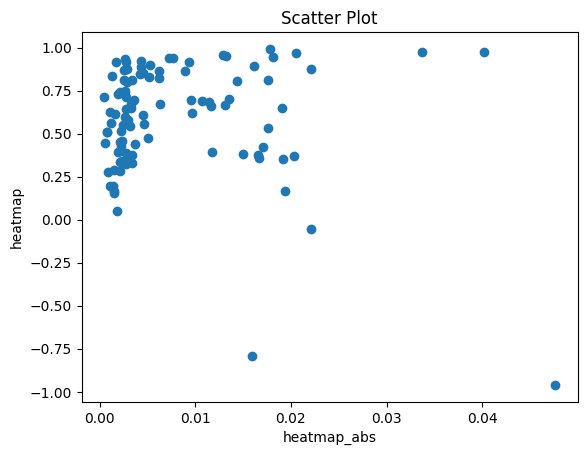

In [26]:
import matplotlib.pyplot as plt

plt.scatter(heatmap_abs[:, :].flatten(), heatmap[:, :].flatten())
plt.xlabel('heatmap_abs')
plt.ylabel('heatmap')
plt.title('Scatter Plot')
plt.show()

In [ ]:
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import plotly.graph_objects as go
import jax.numpy as jnp

ies = {
    "resid": circuitizer.ie_resid,
    "attn_out": circuitizer.ie_attn,
    "transcoder": circuitizer.ie_transcoder,
}


mask_names = circuitizer.masks.keys()


def calc_effects(token_type, feature_type):
    effects = {}
    
    for layer in tqdm(layers_to_check):
        try:
            node_ies = circuitizer.mask_average(ies[feature_type][layer], token_type)
        except KeyError:
            continue
        non_zero_idx = np.where(node_ies != 0)[0]
        feat_metrics = []

        feat_metrics = circuitizer.run_single_feature_ablations(
            non_zero_idx, layer, token_type, feature_type, takers
        )

        effects[layer] = {
            "ies": node_ies[non_zero_idx],
            "metrics": [orig_metric - metric for metric in feat_metrics],
            "idx": non_zero_idx,
        }

    return effects

combined_effects = {}

for feature_type in ["resid", "attn_out", "transcoder"]:
    for token_type in ["input", "arrow", "output"]:
        effects = calc_effects(token_type, feature_type)
        combined_effects[(token_type, feature_type)] = effects

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go       

row_titles = []
# token_types = [f"prompt_{i}" for i in range(0, 5)]    

for ii, token_type in enumerate(token_types):
    for jj, feature_type in enumerate(["resid", "attn_out", "transcoder"]):
        row_titles.append(f"{token_type} {feature_type}")

fig = make_subplots(rows=len(token_types) * 3, cols=len(layers_to_check), column_titles=[f"Layer {layer}" for layer in layers_to_check], row_titles=row_titles)
for layer in layers_to_check:
    for ii, token_type in enumerate(token_types):
        for jj, feature_type in enumerate(["resid", "attn_out", "transcoder"]):
            effects = transformed_effects[layer][token_type][feature_type]
            # print(effects)
            # for layer in layers_to_check:
            #     if layer not in effects:
            #         continue
            ies = effects["ies"]
            metrics = effects["metrics"]
            idx = effects["idx"]
            
            fig.add_trace(go.Scatter(x=ies, y=metrics, mode="markers", marker=dict(size=5)), row=ii*3 + jj + 1, col=layer-1)
            # linear fit
            if len(ies) > 0:
                m, b = np.polyfit(np.array(ies), np.array(metrics), 1)
                # print(ies, m
                trace = go.Scatter(x=ies, y=m*np.array(ies) + b, mode="lines", line=dict(color="red"))

                fig.add_trace(trace, row=ii*3 + jj + 1, col=layer-1)

            # x = y
                fig.add_trace(go.Scatter
                                (x=[min(ies), max(ies)], y=[min(ies), max(ies)], mode="lines", line=dict(color="black")), row=ii*3 + jj + 1, col=layer-1)
            

            #wrtie r2
                # r2 = np.corrcoef(ies, metrics)[0, 1] ** 2
                # fig.add_annotation(
                #     # x=0.5,
                #     # y=0.9,
                #     xref=f"x{layer-1}",
                #     yref=f"y{ii*3 + jj + 1}",

                #     text=f"r^2: {r2:.2f}",
                #     showarrow=False,
                #     font=dict(
                #         size=16,
                #     )
                # )


                # cc = np.corrcoef(ies, metrics)[0, 1]
                # fig.add_annotation(
                #     x=1 * max(ies),
                #     y=0.5 * max(metrics),

                #     text=f"cc: {cc:.2f}",
                #     showarrow=False,
                #     font=dict(
                #         size=16,
                #     ),
                #     row=ii*3 + jj + 1,
                #     col=layer-1
                # )

            # fig.update_xaxes(title_text="IE", row=ii*3 + jj + 1, col=layer-1)


fig.update_layout(height=2500, width=4000, title="Antonyms")
fig.show()

In [22]:
import plotly.express as px 

heatmap = np.zeros((9, len(layers_to_check)))

for ii, token_type in enumerate(["input", "output", "arrow"]):
    for jj, feature_type in enumerate(["resid", "attn_out", "transcoder"]):
        effects = combined_effects[(token_type, feature_type)]
        for layer in layers_to_check:
            if layer not in effects:
                continue
            ies = effects[layer]["ies"]
            metrics = effects[layer]["metrics"]
            idx = effects[layer]["idx"]

            if len(ies) > 0:
                corrcoef = np.corrcoef(ies, metrics)[0, 1]

                heatmap[ii*3 + jj, layer-2] = corrcoef

px.imshow(heatmap, x=layers_to_check, y=row_titles, title="Antonyms", labels={"x": "Layer", "y": "Token Type, Feature Type"}).show()

# px.line(heatmap.mean(axis=0), title="Antonyms", labels={"x": "Layer", "y": "Mean Correlation Coefficient"}).show()

# heatmap.shape

In [ ]:
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import plotly.graph_objects as go


# average_over_positions = True

layers_to_check = list(range(2, 18))

fig = make_subplots(rows=len(layers_to_check), cols=1, subplot_titles=[f"Layer {layer}" for layer in layers_to_check])

for layer in layers_to_check:
    arrow_node_ies = circuitizer.mask_average(circuitizer.ie_attn[layer], "arrow")
    non_zero_idx = np.where(arrow_node_ies != 0)[0]

    feat_metrics = []

    for idx in tqdm(non_zero_idx):
        resid_mask = [idx]

        attn_out_mask = []
        transcoder_mask = []

        feat_masks = dict([
            ("resid", {}),
            ("attn_out", {"arrow": (idx,)}),
            ("transcoder", {}),
        ])

        ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics([0], inverse=inverse, 
                                                                      do_abs=do_abs, mean_ablate=mean_ablate, 
                                                                      average_over_positions=average_over_positions,
                                                                      token_prefix=None, layers=[layer],
                                                                      feature_masks=feat_masks, silent=True)


        feat_metrics.append(ablated_metrics[0])

    fig.add_trace(go.Scatter(x=arrow_node_ies[non_zero_idx], y=[orig_metric - x for x in feat_metrics], mode='markers'), row=layer-1, col=1)


for i in range(1, len(layers_to_check)):
    fig['layout'][f'xaxis{i}']['title']='IE'
    fig['layout'][f'yaxis{i}']['title']='Metric delta'


fig.update_layout(
    height=10000,
    title="Non-zero arrow nodes for attn out"
)
fig


In [ ]:
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import plotly.graph_objects as go


# average_over_positions = True

layers_to_check = list(range(2, 18))

fig = make_subplots(rows=len(layers_to_check), cols=1, subplot_titles=[f"Layer {layer}" for layer in layers_to_check])

for layer in layers_to_check[:-1]:
    arrow_node_ies = circuitizer.mask_average(circuitizer.ie_transcoder[layer], "arrow")
    non_zero_idx = np.where(arrow_node_ies != 0)[0]

    feat_metrics = []

    for idx in tqdm(non_zero_idx):
        resid_mask = [idx]

        attn_out_mask = []
        transcoder_mask = []

        feat_masks = dict([
            ("resid", {}),
            ("attn_out", {}),
            ("transcoder", {"arrow": (idx,)}),
        ])

        ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics([0], inverse=inverse, 
                                                                      do_abs=do_abs, mean_ablate=mean_ablate, 
                                                                      average_over_positions=average_over_positions,
                                                                      token_prefix=None, layers=[layer],
                                                                      feature_masks=feat_masks, silent=True)


        feat_metrics.append(ablated_metrics[0])

    fig.add_trace(go.Scatter(x=arrow_node_ies[non_zero_idx], y=[orig_metric - x for x in feat_metrics], mode='markers'), row=layer-1, col=1)



fig.update_layout(
    height=10000,
    title="Non-zero arrow nodes"
)
fig


In [25]:
for i in range(1, len(layers_to_check)):
    fig['layout'][f'xaxis{i}']['title']='IE'
    fig['layout'][f'yaxis{i}']['title']='Metric delta'

In [ ]:
fig.update_layout(
    title="Non-zero arrow nodes for transcoder"
)

fig

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

layers_to_check = list(range(2, 18))

fig = make_subplots(rows=len(layers_to_check), cols=1, subplot_titles=[f"Layer {layer}" for layer in layers_to_check])

for layer in layers_to_check:
    arrow_node_ies = circuitizer.mask_average(circuitizer.ie_transcoder[layer], "output")
    non_zero_idx = np.where(arrow_node_ies != 0)[0]

    feat_metrics = []

    for idx in tqdm(non_zero_idx):
        resid_mask = [idx]

        attn_out_mask = []
        transcoder_mask = []

        feat_masks = dict([
            ("resid", {"output": (idx,)}),
            ("attn_out", {}),
            ("transcoder", {}),
        ])

        ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics([0], inverse=inverse, 
                                                                      do_abs=do_abs, mean_ablate=mean_ablate, 
                                                                      average_over_positions=average_over_positions,
                                                                      token_prefix=None, layers=[layer],
                                                                      feature_masks=feat_masks, silent=True)


        feat_metrics.append(ablated_metrics[0])

    fig.add_trace(go.Scatter(x=arrow_node_ies[non_zero_idx], y=[orig_metric - x for x in feat_metrics], mode='markers'), row=layer-1, col=1)



fig.update_layout(
    height=10000,
)
fig


  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

KeyError: 17

In [ ]:
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import plotly.graph_objects as go


average_over_positions = True

layers_to_check = list(range(2, 18))

fig = make_subplots(rows=len(layers_to_check), cols=1, subplot_titles=[f"Layer {layer}" for layer in layers_to_check])

for layer in layers_to_check:
    arrow_node_ies = circuitizer.mask_average(circuitizer.ie_resid[layer], "arrow")
    non_zero_idx = np.where(arrow_node_ies != 0)[0]

    feat_metrics = []

    for idx in tqdm(non_zero_idx):
        resid_mask = [idx]

        attn_out_mask = []
        transcoder_mask = []

        feat_masks = dict([
            ("resid", {"arrow": (idx,)}),
            ("attn_out", {}),
            ("transcoder", {}),
        ])

        ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics([0], inverse=inverse, 
                                                                      do_abs=do_abs, mean_ablate=mean_ablate, 
                                                                      average_over_positions=average_over_positions,
                                                                      token_prefix=None, layers=[layer],
                                                                      feature_masks=feat_masks, silent=True)


        feat_metrics.append(ablated_metrics[0])

    fig.add_trace(go.Scatter(x=arrow_node_ies[non_zero_idx], y=[orig_metric - x for x in feat_metrics], mode='markers'), row=layer-1, col=1)



fig.update_layout(
    height=10000,
    title="Non-zero arrow nodes"
)
fig


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

layers_to_check = list(range(2, 18))

fig = make_subplots(rows=len(layers_to_check), cols=1, subplot_titles=[f"Layer {layer}" for layer in layers_to_check])

for layer in layers_to_check:
    arrow_node_ies = circuitizer.mask_average(circuitizer.ie_resid[layer], "output")
    non_zero_idx = np.where(arrow_node_ies != 0)[0]

    feat_metrics = []

    for idx in tqdm(non_zero_idx):
        resid_mask = [idx]

        attn_out_mask = []
        transcoder_mask = []

        feat_masks = dict([
            ("resid", {"output": (idx,)}),
            ("attn_out", {}),
            ("transcoder", {}),
        ])

        ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics([0], inverse=inverse, 
                                                                      do_abs=do_abs, mean_ablate=mean_ablate, 
                                                                      average_over_positions=average_over_positions,
                                                                      token_prefix=None, layers=[layer],
                                                                      feature_masks=feat_masks, silent=True)


        feat_metrics.append(ablated_metrics[0])

    fig.add_trace(go.Scatter(x=arrow_node_ies[non_zero_idx], y=[orig_metric - x for x in feat_metrics], mode='markers'), row=layer-1, col=1)



fig.update_layout(
    height=10000,
)
fig


In [39]:

fig.update_layout(
    height=2000,
)
fig


In [34]:
import plotly.express as px

fig = px.scatter(x=arrow_node_ies[non_zero_idx], y=[orig_metric - x for x in feat_metrics], labels = {
    "x": "IE",
    "y": "Metric change"
})

# [orig_metric - x for x in feat_metrics]

fig